In [1]:
## VAG Preliminary Tests

from __future__ import division
import pandas as pd
import numpy as np
from scipy.signal import medfilt, butter, filtfilt, lfilter, find_peaks, find_peaks_cwt,resample, detrend
# wwelches test
from scipy.signal import welch, spectrogram, get_window
import urllib.parse
import logging
import math
import time
import statistics as stats
import json
from datetime import datetime, timedelta
import os, sys
import matplotlib.pyplot as plt

## required functions

# pass in 3 axis as a []
def vector_magnitude(vectors):
    n = len(vectors[0])
    assert all(len(v) == n for v in vectors), "Vectors have different lengths"
    vm = np.sqrt(sum(v ** 2 for v in vectors))
    return vm

def build_filter(frequency, sample_rate, filter_type, filter_order):
    #nyq = 0.5 * sample_rate
    if filter_type == "bandpass":
        #nyq_cutoff = (frequency[0] / nyq, frequency[1] / nyq)
        b, a = butter(filter_order, (frequency[0], frequency[1]), btype=filter_type, analog=False, output='ba', fs=sample_rate)
    elif filter_type == "low":
        #nyq_cutoff = frequency[1] / nyq
        b, a = butter(filter_order, frequency[1] / ny, btype=filter_type, analog=False, output='ba', fs=sample_rate)
    elif filter_type == "high":
        #nyq_cutoff = frequency[0] / nyq
        b, a = butter(filter_order, frequency[0], btype=filter_type, analog=False, output='ba', fs=sample_rate)
    else:
        nyq_cutoff = frequency / nyq
    return b, a
                 
def filter_signal(b, a, signal, filter):
    if(filter=="lfilter"):
        return lfilter(b, a, signal)
    elif(filter=="filtfilt"):
        return filtfilt(b, a, signal)
    elif(filter=="sos"):
        return sosfiltfilt(sos, signal)
    
def compute_fft_mag(data):
    fftpoints = int(math.pow(2, math.ceil(math.log2(len(data)))))
    fft = np.fft.fft(data, n=fftpoints)
    mag = np.abs(fft) / (fftpoints/2)
    return mag

# assumes a numpy arrray
def compute_power_spectrum(fft_mag):
    power = np.square(fft_mag)
    return power

def fft_graph_values(data, sample_rate):
    T = 1/sample_rate
    N_r =len(data)//2
    x = np.linspace(0.0, 1.0/(2.0*T), len(data)//2).tolist()
    y = data[:N_r]
    return [x,y]

In [38]:
#filter parameters
low_cut_off = 100  # removes muscle artifacts and baseline wander
high_cut_off = 999
filter_order = 5   # 9th order has been used in literature?
filter_type =  "high"  #"bandpass"
sampling_rate = 2000

In [39]:
## dummy signal
duration = 5  # Duration in seconds
# Generate time vector
t = np.arange(0, duration, 1.0 / sampling_rate)
freq0 = 50   # frequency to filter out 
freq1 = 200  # Frequency of the first sine wave (Hz)
freq2 = 450  # Frequency of the second sine wave (Hz)
freq3 = 125

# Generate the signal
signal = np.sin(2 * np.pi * freq3 * t) + np.sin(2 * np.pi * freq0 * t) + np.sin(2 * np.pi * freq1 * t) + np.sin(2 * np.pi * freq2 * t) + 0.5 * np.random.randn(len(t))

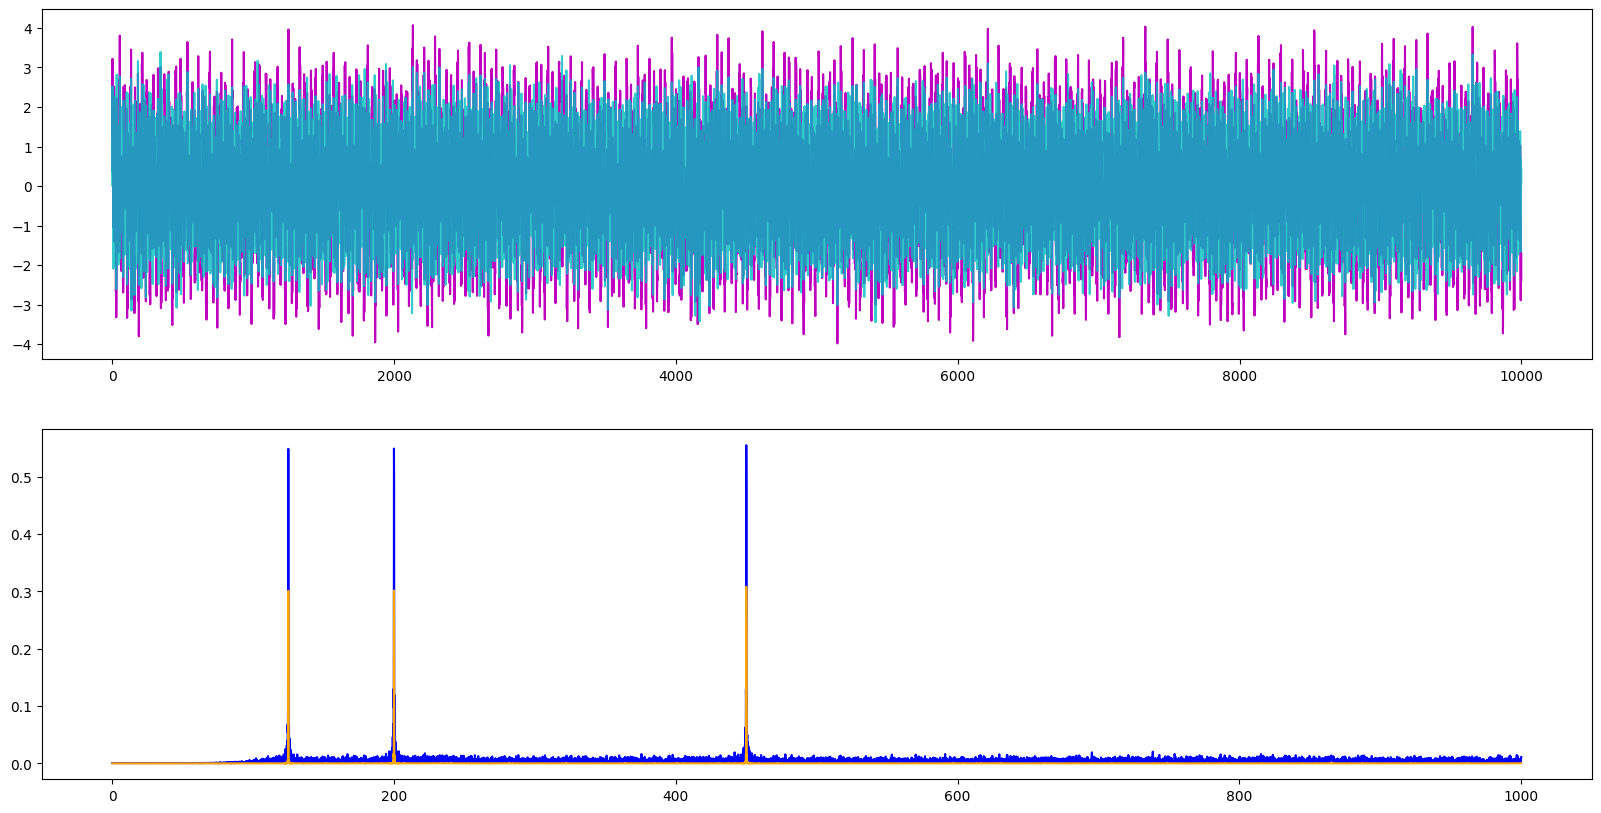

In [40]:
#filter (highpass only uses low_cutoff)
# this may not be required for welches method or other time-frequency decomposition
b,a = build_filter((low_cut_off, high_cut_off), sampling_rate, filter_type, filter_order)
f_signal = filter_signal(b,a, signal, "filtfilt")

f_mag = compute_fft_mag(f_signal)
fft_graph = fft_graph_values(f_mag, sampling_rate)
f_power = compute_power_spectrum(fft_graph[1])

#plot fft
fig, ax = plt.subplots(2,1, figsize=(20, 10))

# add plots
ax[0].plot(signal,color="m")
ax[0].plot(f_signal, color="c", alpha=0.8)
#ax[1].plot(fft_freq, fft, linewidth=2, color="black", label="Frequency Response")
ax[1].plot(fft_graph[0], fft_graph[1], color="blue")
ax[1].plot(fft_graph[0], f_power, color="orange")

In [44]:
# compute the total power in the signal
total_power =  round(np.sum(f_power),2)
print(f"total power: {total_power}")

total power: 1.98


In [45]:
fft_freq = np.array(fft_graph[0])
# creates 50 hz bands which could be too small
f_bands = [(f, f + 50) for f in range(100, 1000, 50)]
band_powers = []


for (low, high) in f_bands:
    band_power = np.sum(f_power[(fft_freq >= low) & (fft_freq < high)])
    band_powers.append(band_power)

# computes the percentage contribution of each frequency band
band_percentages = [(bp / total_power) * 100 for bp in band_powers]

for idx, (low,high) in enumerate(f_bands):
    print(f"f band {low, high} % power {band_percentages[idx]}")

f band (100, 150) % power 25.458648543770003
f band (150, 200) % power 18.095908949067358
f band (200, 250) % power 14.381742555088106
f band (250, 300) % power 0.7390188642763618
f band (300, 350) % power 0.7011515232002546
f band (350, 400) % power 0.8100234633258485
f band (400, 450) % power 2.905274592835899
f band (450, 500) % power 29.553150670980937
f band (500, 550) % power 0.6943213517351734
f band (550, 600) % power 0.7013510886184497
f band (600, 650) % power 0.7552621759783038
f band (650, 700) % power 0.7639558400041236
f band (700, 750) % power 0.7804150943721828
f band (750, 800) % power 0.7706793594780995
f band (800, 850) % power 0.8148054002293631
f band (850, 900) % power 0.7569458371138136
f band (900, 950) % power 0.7024905261961318
f band (950, 1000) % power 0.7611156294298728


Text(0, 0.5, 'frequency')

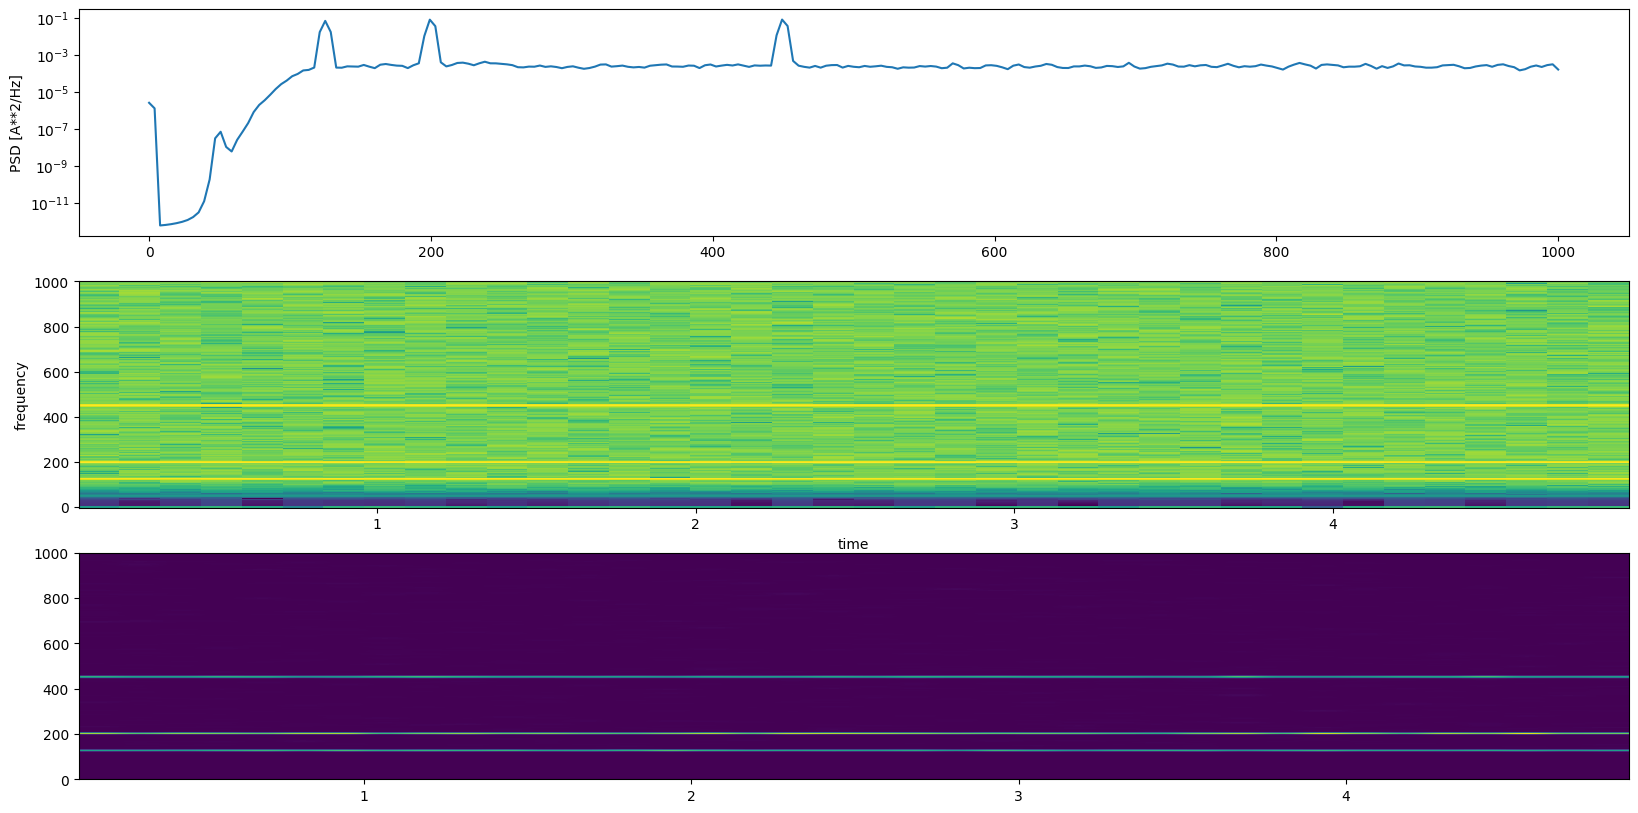

In [46]:
# 2000 hz for 5 seconds = 10000 samples
# 10000 / 512 = 20 windows approximately
segment_length = 512  # Length of each segment
overlap = segment_length // 2  # 50% overlap
window = get_window('hann', segment_length)  # Hann window

# Compute the power spectral density
f_welch, psd = welch(f_signal, fs=sampling_rate, window=window, nperseg=segment_length, noverlap=overlap, scaling='density')

# scaling="density" scaling="spectrum"
frequencies, times, Sxx = spectrogram(f_signal, fs=sampling_rate, window=window, nperseg=segment_length, noverlap=overlap, scaling='density')

fig, ax = plt.subplots(3,1, figsize=(20, 10))
ax[0].semilogy(f_welch, psd)
ax[1].pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='auto')
ax[2].imshow(Sxx, aspect='auto', cmap='viridis', origin='lower', extent=[times.min(), times.max(), frequencies.min(), frequencies.max()])

ax[0].set_ylabel('PSD [A**2/Hz]')
ax[1].set_xlabel("time")
ax[1].set_ylabel("frequency")